# 🚀 RLCS Match-Level Outcome Prediction

## Imports

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

## 1️⃣ Problem Formulation : Predict RLCS Match Outcomes
In this project, we aim to build a classification model that predicts the outcome of a Rocket League Championship Series (RLCS) match.

Each match consists of two teams, Blue and Orange. We extracted team statistics through Ballchasing.com to form our dataset. With this data we formulated a binary classification problem, where we try to predict the winner. Our target variable 1 = Blue team wins, and 0 = Orange team wins.

The features used to train our model include boost usage, goals, possession, and other performance stats. With these we aim to understand patterns in team performance, evaluate strategies, and make predictions on future matches.

## 2️⃣ Gathering Data - Combine Pro CSV Team Data

**Combined csv files with help from ChatGPT**

In [16]:
def combine_rlcs_team_csvs(folder_path, output_path="training_data.csv"):
    combined_rows = []

    for file in os.listdir(folder_path):
        if file.endswith("-teams.csv"):
            file_path = os.path.join(folder_path, file)
            replay_id = file.replace("-teams.csv", "")

            try:
                # Use delimiter=";" because current CSVs use ; instead of ,
                df = pd.read_csv(file_path, delimiter=";")

                if "color" not in df.columns:
                    print(f"Skipping {file} — no 'color' column.")
                    continue

                # Clean and match team colors
                df["color_cleaned"] = df["color"].astype(str).str.strip().str.lower()

                if df.shape[0] != 2 or not {"blue", "orange"}.issubset(set(df["color_cleaned"])):
                    print(f"Skipping {file} — missing one of the teams.")
                    continue

                # Split blue/orange team rows
                blue = df[df["color_cleaned"] == "blue"].drop(columns=["color_cleaned"]).add_prefix("blue_").reset_index(drop=True)
                orange = df[df["color_cleaned"] == "orange"].drop(columns=["color_cleaned"]).add_prefix("orange_").reset_index(drop=True)

                # Merge both into one row
                merged = pd.concat([blue, orange], axis=1)
                merged["replay_id"] = replay_id
                merged["winner"] = int(blue["blue_goals"].iloc[0] > orange["orange_goals"].iloc[0])

                combined_rows.append(merged)

            except Exception as e:
                print(f"Error processing {file}: {e}")

    if combined_rows:
        final_df = pd.concat(combined_rows, ignore_index=True)
        final_df.to_csv(output_path, index=False)
        print(f"\nFinal training dataset saved to: {output_path}")
        return final_df
    else:
        print("No valid files processed.")
        return None

## 3️⃣ Data Exploration

In [17]:
csv_folder = "training_csvs"
combined_df = combine_rlcs_team_csvs(csv_folder)
combined_df.head()



Final training dataset saved to: training_data.csv


,blue_color,blue_team name,blue_game duration,blue_score,blue_goals,blue_assists,blue_saves,blue_shots,blue_shots conceded,blue_goals conceded,...,orange_time offensive half,orange_time defensive third,orange_time neutral third,orange_time offensive third,orange_time ball possession,orange_time ball in own side,orange_demos inflicted,orange_demos taken,replay_id,winner
0,blue,NaN,220,374,0,0,2,5,6,3,...,236.12,325.02,195.16,138.80,83.48,87.90,0,1,00bdc313-63e7-4b36-afc0-cc99eaf6c5b0,0
1,blue,NaN,340,987,1,1,6,8,11,2,...,411.26,421.44,316.27,261.18,128.20,145.13,2,7,0197dfb3-18bc-4dd4-8329-6e8b4844462a,0
2,blue,NaN,358,1034,2,2,5,6,10,3,...,413.22,486.97,322.38,256.45,156.58,158.41,3,2,043d000e-5fed-4e64-bbbc-4b75edb6de37,0
3,blue,NaN,348,1017,2,1,5,8,11,4,...,391.57,478.77,311.89,247.07,136.28,146.43,1,1,04f4f440-039c-41e0-9be6-c8a40ca92365,0
4,blue,MOIST ESPORTS,485,1515,1,1,11,7,15,2,...,714.78,459.62,556.75,423.16,235.87,142.53,10,4,05e4d7ff-50eb-424d-910a-8eafc943ee33,0


## 4️⃣ Data Visualization

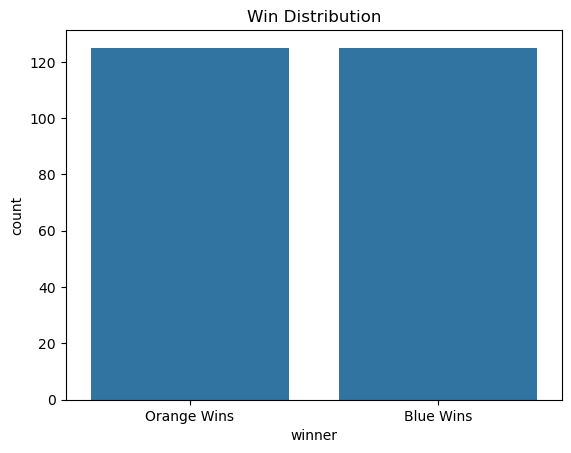

In [18]:
sns.countplot(data=combined_df, x="winner")
plt.xticks([0, 1], ["Orange Wins", "Blue Wins"])
plt.title("Win Distribution")
plt.show()

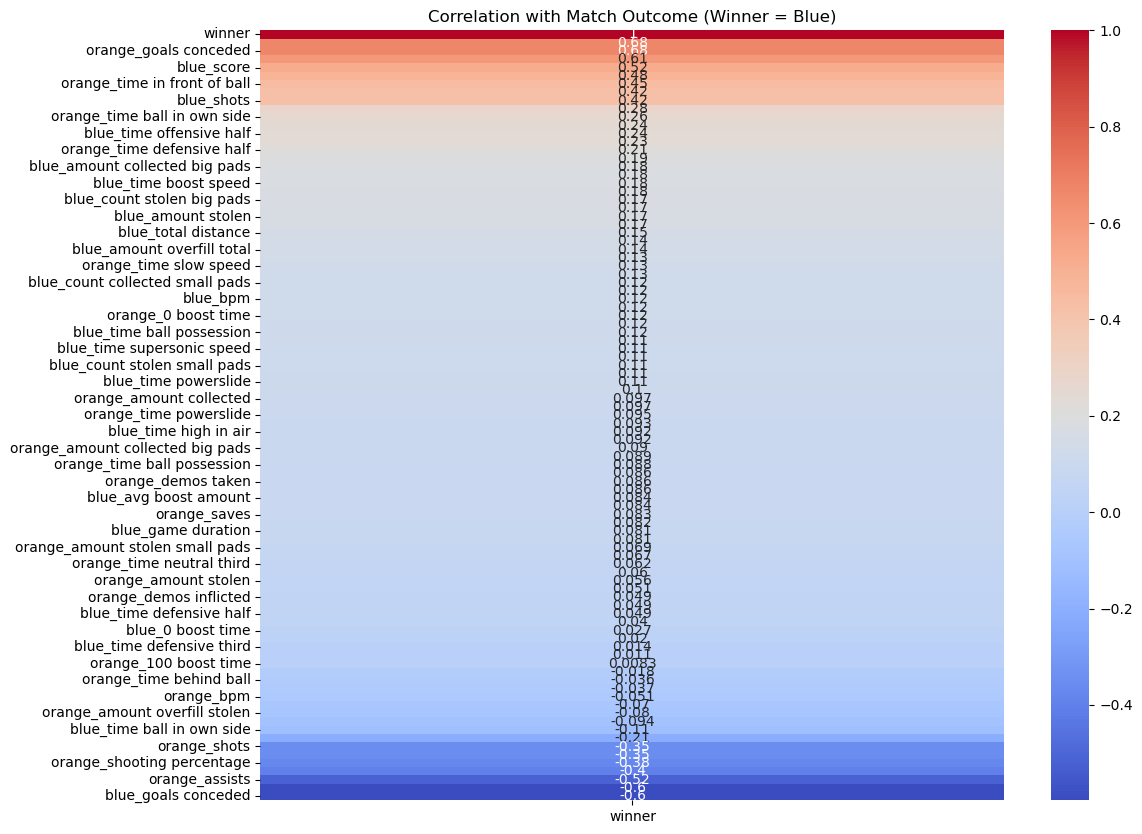

In [19]:
numeric_df = combined_df.select_dtypes(include="number").copy()
corr = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr[["winner"]].sort_values(by="winner", ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlation with Match Outcome (Winner = Blue)")
plt.show()


## 5️⃣ Data Preprocessing

In [20]:
# Load training data
df = pd.read_csv("training_data.csv")

# Drop outcome-leaking columns
X = df.drop(columns=[
    "winner",             
    "replay_id",          
    "blue_color", "orange_color",                
    "blue_team name", "orange_team name",        
    "blue_score", "orange_score",                
    "blue_goals", "orange_goals",
    "blue_goals conceded", "orange_goals conceded",
    "blue_shots conceded", "orange_shots conceded",
    "blue_assists", "orange_assists",
    "blue_saves", "orange_saves"
], errors="ignore")

# Keep only numeric features
X = X.select_dtypes(include="number")

# Set target
y = df["winner"]

# Show structure
print("X shape:", X.shape)
X.head()


X shape: (250, 80)


,blue_game duration,blue_shots,blue_shooting percentage,blue_bpm,blue_avg boost amount,blue_amount collected,blue_amount collected big pads,blue_amount collected small pads,blue_count collected big pads,blue_count collected small pads,...,orange_time in front of ball,orange_time defensive half,orange_time offensive half,orange_time defensive third,orange_time neutral third,orange_time offensive third,orange_time ball possession,orange_time ball in own side,orange_demos inflicted,orange_demos taken
0,220,5,0.00,1195,154.82,4633,3268,1365,38,120,...,145.48,422.87,236.12,325.02,195.16,138.80,83.48,87.90,0,1
1,340,8,12.50,1189,142.09,6764,4399,2365,56,190,...,272.90,587.63,411.26,421.44,316.27,261.18,128.20,145.13,2,7
2,358,6,33.33,1216,155.91,7063,5046,2017,63,182,...,357.78,652.60,413.22,486.97,322.38,256.45,156.58,158.41,3,2
3,348,8,25.00,1190,136.15,6545,4041,2504,46,212,...,263.86,646.15,391.57,478.77,311.89,247.07,136.28,146.43,1,1
4,485,7,14.29,1045,159.54,8301,5432,2869,71,258,...,335.74,724.75,714.78,459.62,556.75,423.16,235.87,142.53,10,4


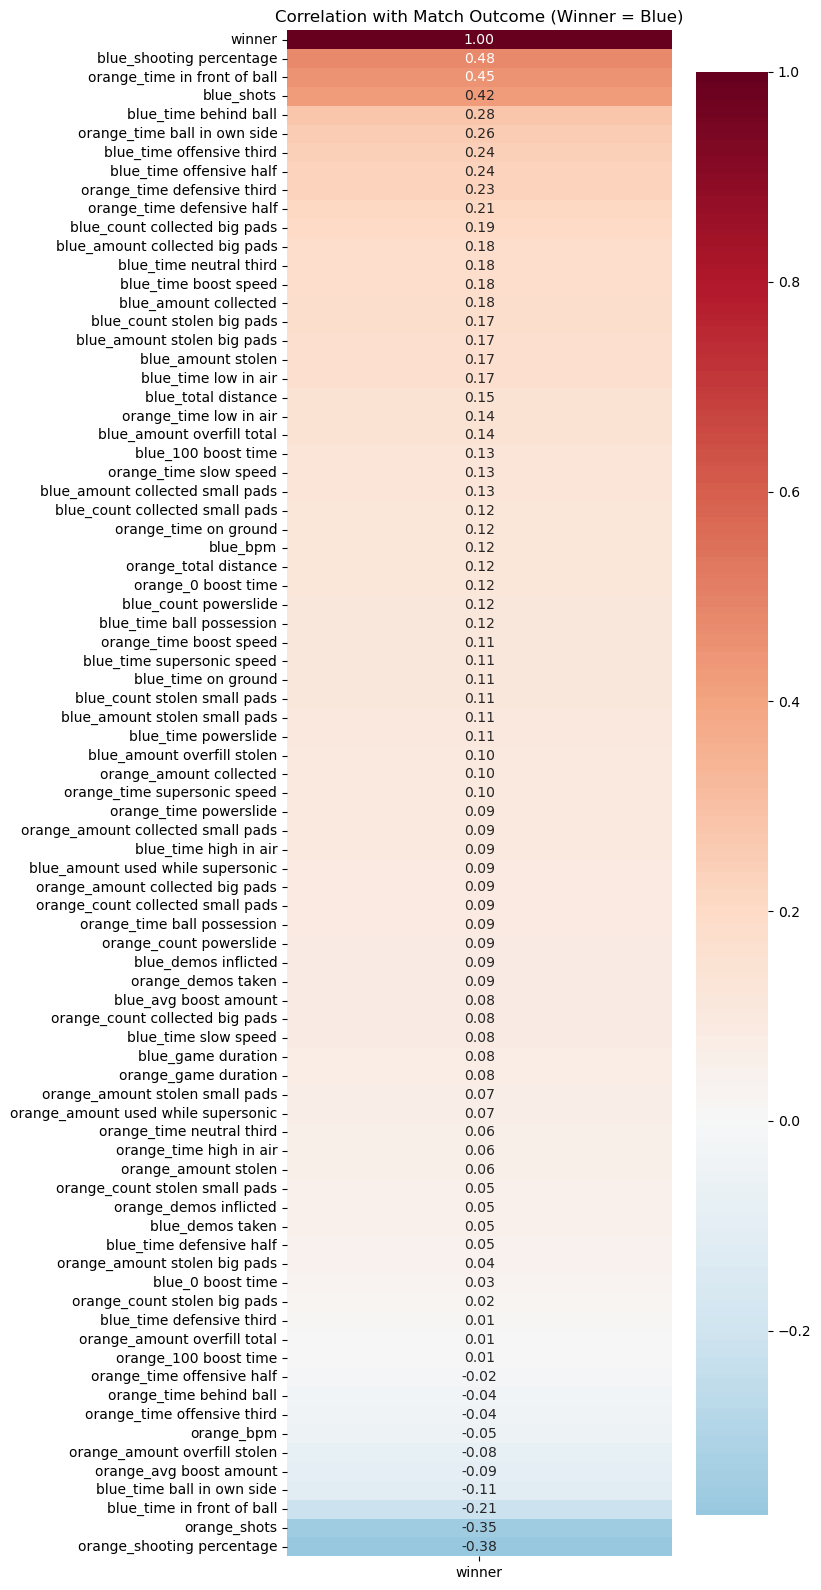

In [21]:
# Add winner just for correlation
X_with_target = X.copy()
X_with_target["winner"] = y

# Compute correlation matrix
corr_matrix = X_with_target.corr()

# Create heatmap of feature correlation with match outcome
plt.figure(figsize=(8, 16))
sns.heatmap(
    corr_matrix[["winner"]].sort_values(by="winner", ascending=False),
    annot=True,
    cmap="RdBu_r",
    center=0,
    fmt=".2f"
)
plt.title("Correlation with Match Outcome (Winner = Blue)")
plt.tight_layout()
plt.show()


## 6️⃣ Training Logistic Regression Model

In [22]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_trn_scaled = scaler.fit_transform(X_trn)
X_tst_scaled = scaler.transform(X_tst)

model = LogisticRegression(max_iter=2000)
model.fit(X_trn_scaled, y_trn)

y_pred = model.predict(X_tst_scaled)

print("✅ Accuracy:", accuracy_score(y_tst, y_pred))
print(classification_report(y_tst, y_pred))


✅ Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.92      0.92      0.92        26

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



## 7️⃣ Model Evaluation / Interpretation

In [23]:
# Represent feature weights
feature_weights = pd.Series(model.coef_[0], index=X.columns)
feature_weights.sort_values(ascending=False).head(10)

blue_shooting percentage            2.365890
blue_shots                          1.254642
orange_time in front of ball        0.782273
blue_time behind ball               0.459442
blue_time boost speed               0.442850
blue_bpm                            0.418768
blue_amount collected small pads    0.393715
blue_time ball possession           0.352529
blue_amount overfill total          0.348797
blue_count collected big pads       0.332532
dtype: float64

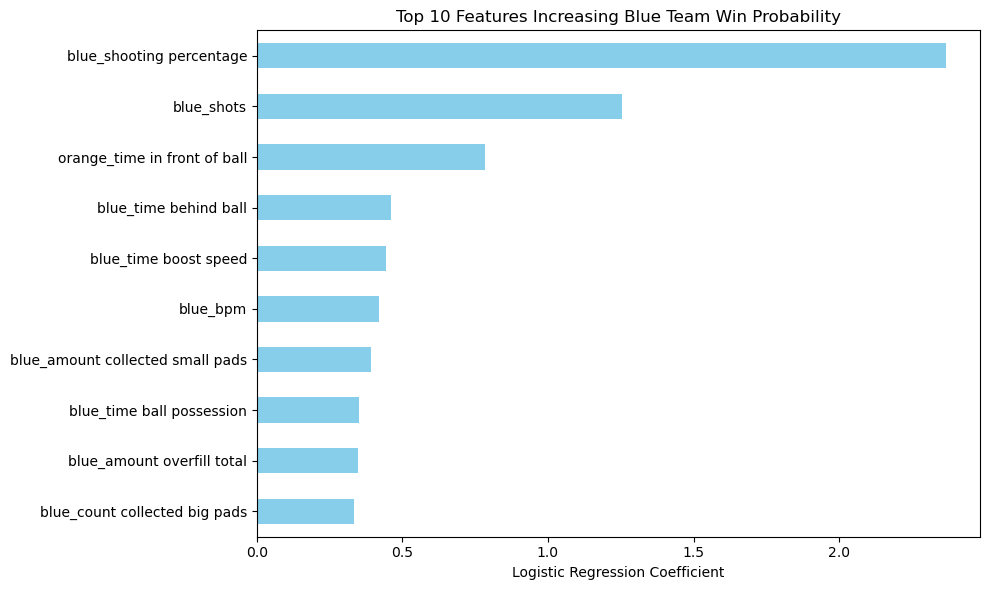

In [24]:
# Represent Most Important Features
top_features = feature_weights.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind="barh", color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Features Increasing Blue Team Win Probability")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

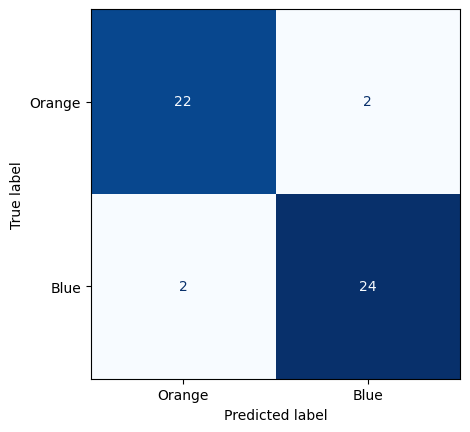

In [25]:
# Display Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    model, X_tst_scaled, y_tst,
    display_labels=["Orange", "Blue"],
    cmap="Blues",
    colorbar=False
)

## 8️⃣ Prediction New Matches Using Trained Model

Using real match CSVs to make match predictions. Also explaining which stats contributed to each outcome.

In [26]:

# Columns dropped during training
columns_to_drop = [
    "winner",             
    "replay_id",          
    "blue_color", "orange_color",                
    "blue_team name", "orange_team name",        
    "blue_score", "orange_score",                
    "blue_goals", "orange_goals",
    "blue_goals conceded", "orange_goals conceded",
    "blue_shots conceded", "orange_shots conceded",
    "blue_assists", "orange_assists",
    "blue_saves", "orange_saves"
]

# Folder with RLCS games to predict
folder_path = "rlcs_matches"

# Loop through each game
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        print(f"\n🔎 Analyzing Match ID: {file}")
        file_path = os.path.join(folder_path, file)

        # Load the CSV
        df_new = pd.read_csv(file_path, delimiter=";")

        # Separate blue and orange teams
        df_new["color_cleaned"] = df_new["color"].astype(str).str.strip().str.lower()
        blue = df_new[df_new["color_cleaned"] == "blue"].drop(columns=["color_cleaned"]).add_prefix("blue_").reset_index(drop=True)
        orange = df_new[df_new["color_cleaned"] == "orange"].drop(columns=["color_cleaned"]).add_prefix("orange_").reset_index(drop=True)
        match_row = pd.concat([blue, orange], axis=1)

        # Drop unused or text columns
        X_new = match_row.drop(columns=columns_to_drop, errors="ignore")
        X_new = X_new.select_dtypes(include="number")

        # Scale and predict
        X_new_scaled = scaler.transform(X_new)
        pred = model.predict(X_new_scaled)[0]
        prob = model.predict_proba(X_new_scaled)[0]

        print("🎯 Predicted Winner:", "🟦 BLUE" if pred == 1 else "🟧 ORANGE")
        print(f"📊 Confidence - Blue: {prob[1]:.2f}, Orange: {prob[0]:.2f}")

        # Contribution from top features
        contributions = X_new_scaled[0] * model.coef_[0]
        feature_contributions = pd.Series(contributions, index=X_new.columns)

        print("\n   🟦 Top BLUE features:")
        print(feature_contributions.sort_values(ascending=False).head(3))

        print("\n   🟧 Top ORANGE features:")
        print(feature_contributions.sort_values().head(3))
        print("__________________________________________________________________________")



🔎 Analyzing Match ID: Raleigh Major - 🟦Team Falcons vs 🟧NRG Game 6 - 2025-06-29 -teams.csv
🎯 Predicted Winner: 🟦 BLUE
📊 Confidence - Blue: 0.68, Orange: 0.32

   🟦 Top BLUE features:
orange_shooting percentage    3.104425
blue_time in front of ball    1.340346
blue_shots                    0.568478
dtype: float64

   🟧 Top ORANGE features:
blue_shooting percentage     -2.373322
orange_shots                 -2.211584
blue_amount overfill total   -0.363508
dtype: float64
__________________________________________________________________________

🔎 Analyzing Match ID: Raleigh Major - 🟦Twisted Minds vs 🟧NRG Game 7 - 2025-06-29 -teams.csv
🎯 Predicted Winner: 🟧 ORANGE
📊 Confidence - Blue: 0.41, Orange: 0.59

   🟦 Top BLUE features:
orange_shooting percentage       1.141540
blue_amount overfill total       1.069095
blue_count collected big pads    0.419012
dtype: float64

   🟧 Top ORANGE features:
blue_shooting percentage   -1.284311
orange_shots               -1.111294
blue_shots           

## 9️⃣ Conclusion

In conclusion, we built a logistic regression model to predict the outcome of Rocket League matches using team-level performance stats from Ballchasing.com.

### Key Takeaways

**Model Accuracy:**
 - The model achieved a 92% accuracy on the test data, showing the model is accurate but could use improvements.
 - Precision: 0.92
 - Recall: 0.92
 - F1-Score: 0.92
   

**Feature Selection:**

Certain columns were removed do to possible data leaks or irrelevance, such as:
 - Final match scores
 - Team names and colors
 - Total goals/assists
   
**Future Improvements:**

 - Test other models
 - Include player-level data
 - Use time-series features as well as team-level data for deeper prediction model

Overall, this project represents the beginning of the possibilites for machine learning and esports analytics. In the future we will be able to have more informed predictions from in-game data, and maybe even make predictions in real time.